In [21]:
import os, sys, inspect

cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)


cmd_subfolder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"lib/Leap")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)
    cmd_subfolder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"lib/Anderson")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)

In [22]:
import pandas as pd
import numpy as np
import neuralnetworks as nn
import mlutils as ml

In [23]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    import neuralnetworks as nn
    import mlutils as ml
    import numpy as np
    import time
    result = []
    for structure in hiddenLayerStructures:
        trainedResult = []
        testResult = []
        t0 = time.time()
        for n in range(0, numberRepetitions):
            Xtrain,Ttrain,Xtest,Ttest = ml.partition(X,T,(trainFraction, 1-trainFraction),classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], structure, len(np.unique(T)))
                nnet.train(Xtrain, Ttrain, numberIterations, errorPrecision=1.e-8)
                trainedResult.append(np.sum(nnet.use(Xtrain)==Ttrain)/len(Ttrain))
                testResult.append(np.sum(nnet.use(Xtest)==Ttest)/len(Ttest))
            else:
                nnet = nn.NeuralNetwork(X.shape[1], structure, T.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
                trainedResult.append(np.sqrt(np.mean(((nnet.use(Xtrain)-Ttrain)**2))))
                testResult.append(np.sqrt(np.mean(((nnet.use(Xtest)-Ttest)**2))))

            
        result.append([structure, trainedResult, testResult, time.time() - t0])
    return result

def summarize(results):
    import numpy as np
    summaryResults = []
    for result in results:
        summaryResults.append([result[0], np.mean(result[1]), np.mean(result[2]), result[3]])
    return summaryResults


def bestNetwork(summary):
    best = min(summary, key=lambda l: l[2])
    return best


Dependencies/import config

## Get Data

In [24]:
data = pd.read_csv("templates/data1Normed.csv")
names = list(data)
data["signcode"] = data["sign"].astype('category').cat.codes
data = data.values

In [25]:
Xhands = data[:, 0:63]
Xhands = Xhands.astype(np.float64)

In [26]:
Tsign = data[:, 64:65]
Tsign = Tsign.astype(np.int32)

In [27]:
Xhands.shape

(1973, 63)

In [28]:
Tsign.shape

(1973, 1)

In [29]:
handNames = names[0:63]
signName = names[63]

In [30]:
for i in range(0, len(np.unique(Tsign).tolist())):
    print('{} samples in class {} sign: {} '.format(np.sum(Tsign==i), i, np.unique(data[:, 63]).tolist()[i]))

107 samples in class 0 sign: a 
78 samples in class 1 sign: b 
63 samples in class 2 sign: c 
101 samples in class 3 sign: d 
50 samples in class 4 sign: e 
84 samples in class 5 sign: f 
45 samples in class 6 sign: g 
66 samples in class 7 sign: h 
84 samples in class 8 sign: i 
113 samples in class 9 sign: j 
84 samples in class 10 sign: k 
97 samples in class 11 sign: l 
38 samples in class 12 sign: m 
67 samples in class 13 sign: n 
62 samples in class 14 sign: o 
66 samples in class 15 sign: p 
109 samples in class 16 sign: q 
97 samples in class 17 sign: r 
71 samples in class 18 sign: s 
71 samples in class 19 sign: t 
66 samples in class 20 sign: u 
61 samples in class 21 sign: v 
70 samples in class 22 sign: w 
81 samples in class 23 sign: x 
104 samples in class 24 sign: y 
38 samples in class 25 sign: z 


Get list of how many samples in each class/category/how many of each sign.

## Test NNet

In [31]:
results = trainNNs(Xhands, Tsign, 0.90, [5], 10, 100, classify=True)

In [32]:
results

[[5,
  [0.58760563380281694,
   0.65521126760563375,
   0.64112676056338025,
   0.61464788732394371,
   0.62591549295774651,
   0.6507042253521127,
   0.65746478873239433,
   0.61352112676056336,
   0.68225352112676052,
   0.65014084507042258],
  [0.54822335025380708,
   0.62436548223350252,
   0.65989847715736039,
   0.59390862944162437,
   0.5532994923857868,
   0.56345177664974622,
   0.6142131979695431,
   0.57360406091370564,
   0.65482233502538068,
   0.57868020304568524],
  48.07427930831909]]

In [33]:
summarize(results)

[[5, 0.63785915492957757, 0.59644670050761428, 48.07427930831909]]

In [34]:
bestNet = bestNetwork(summarize(results))
bestNet

[5, 0.63785915492957757, 0.59644670050761428, 48.07427930831909]

## Plot the test

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

#run best on 
Xtrain,Ttrain,Xtest,Ttest = ml.partition(Xhands,Tsign,(0.8, 0.2),True)
nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], bestNet[0], len(np.unique(Ttrain)))
nnet.train(Xtrain, Ttrain, 100)

NeuralNetwork(63, [5], 26)
   Network was trained for 100 iterations. Final error is 0.05010960019849873.

In [36]:
result = nnet.use(Xtest)

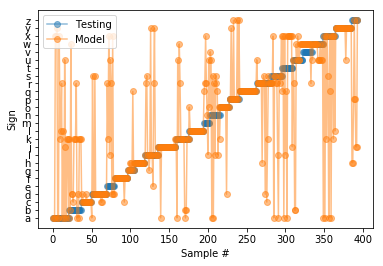

In [37]:
#plt.subplot(3, 1, 1)
plt.plot(Ttest, 'o-', alpha=0.5)
plt.plot(result, "o-", alpha=0.5)

labels = np.unique(data[:, 63])
plt.xlabel("Sample #")
plt.ylabel("Sign")

plt.yticks(np.unique(Ttest).tolist(), np.unique(labels).tolist())

plt.legend(('Testing','Model'), loc='upper left')

vs